In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

X = train_df.drop('label', axis=1)
y = train_df['label']

del train_df

In [6]:
X = X / 255.0
test_df = test_df / 255.0

X = X.values.reshape(-1, 28, 28, 1)
test_df = test_df.values.reshape(-1, 28, 28, 1)

y = to_categorical(y, num_classes=10)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

del X
del y

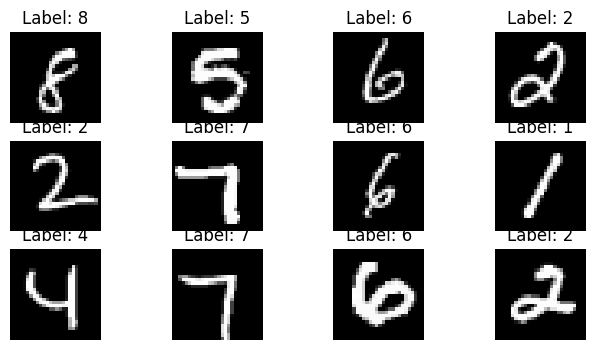

In [33]:
plt.figure(figsize=(8, 4))
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(X_train[i].reshape(28,28),cmap='gray')
    plt.title(f"Label: {np.argmax(y_train[i])}")
    plt.axis("off")
plt.show()

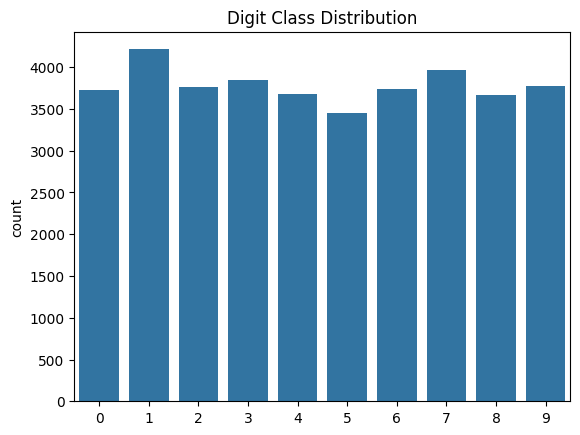

In [32]:
import seaborn as sns
sns.countplot(x=np.argmax(y_train, axis=1))
plt.title("Digit Class Distribution")
plt.show()

In [11]:
y_train

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], shape=(37800, 10))

In [8]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),

    Dense(10, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [13]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=0.00001
)

checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss',
    save_best_only=True
)

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

Epoch 1/20
590/591 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9923 - loss: 0.0245

591/591 ━━━━━━━━━━━━━━━━━━━━ 27s 46ms/step - accuracy: 0.9926 - loss: 0.0235 - val_accuracy: 0.9917 - val_loss: 0.0250 - learning_rate: 5.0000e-04
Epoch 2/20
590/591 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9936 - loss: 0.0187

591/591 ━━━━━━━━━━━━━━━━━━━━ 29s 48ms/step - accuracy: 0.9932 - loss: 0.0204 - val_accuracy: 0.9931 - val_loss: 0.0249 - learning_rate: 5.0000e-04
Epoch 3/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 46s 56ms/step - accuracy: 0.9937 - loss: 0.0193 - val_accuracy: 0.9914 - val_loss: 0.0297 - learning_rate: 5.0000e-04
Epoch 4/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 33s 56ms/step - accuracy: 0.9940 - loss: 0.0194 - val_accuracy: 0.9929 - val_loss: 0.0259 - learning_rate: 5.0000e-04
Epoch 5/20
590/591 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9950 - loss: 0.0150
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
591/591 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.9947 - loss: 0.0165 - val_accuracy: 0.9938 - val_loss: 0.0267 - learning_rate: 5.0000e-04
Epoch 6/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.9953 - loss: 0.0136 - val_accuracy: 0.9924 - val_loss: 0.0258 - learning_rate: 2.5000e-04
Epoch 7/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.9

In [14]:
from tensorflow.keras.models import load_model
best_model = load_model('best_model.h5')

predictions = best_model.predict(test_df)

875/875 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step


In [16]:
loss, accuracy = model.evaluate(X_val, y_val, verbose=0)

print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Loss: 0.0249
Validation Accuracy: 0.9931


In [17]:
from sklearn.metrics import classification_report
import numpy as np

y_pred_probs = model.predict(X_val)

y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.argmax(y_val, axis=1)

print(classification_report(y_true_labels, y_pred_labels))

132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       408
           1       1.00      1.00      1.00       471
           2       1.00      0.99      0.99       420
           3       0.99      0.99      0.99       506
           4       0.99      0.99      0.99       397
           5       0.99      0.99      0.99       339
           6       0.99      1.00      0.99       402
           7       0.99      1.00      0.99       438
           8       0.99      0.99      0.99       403
           9       1.00      1.00      1.00       416

    accuracy                           0.99      4200
   macro avg       0.99      0.99      0.99      4200
weighted avg       0.99      0.99      0.99      4200

